In [12]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline
from fancyimpute import KNN
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
import json
import os
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import time

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
import lightgbm as lgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report

In [13]:
# Read Files (Without Imputation/Resamplign)
X_train = pd.read_csv('../data/output/X_train.csv', index_col=0)
X_test = pd.read_csv('../data/output/X_test.csv', index_col = 0)

y_train = pd.read_csv('../data/output/y_train.csv')['isFraud']
y_test = pd.read_csv('../data/output/y_test.csv')['isFraud']

In [14]:
X_train.shape, y_train.shape

((472432, 308), (472432,))

In [15]:
X_test.shape, y_test.shape

((118108, 308), (118108,))

## Models

#### XGBoost with HyperOpt

In [16]:
# from hyperopt import hp, tpe, fmin, Trials
# from hyperopt.pyll.base import scope
# from sklearn.model_selection import StratifiedKFold
# from xgboost import XGBClassifier
# from sklearn.metrics import roc_auc_score
# import numpy as np
# import time
# import gc

# def objective_xgb(params):
#     time1 = time.time()
#     params['max_depth'] = int(params['max_depth'])
#     params['n_estimators'] = 600  # Fixed number of estimators
#     params['tree_method'] = 'gpu_hist'  # Use GPU for faster training (if supported)
#     params['verbosity'] = 0  # Suppress output for training

#     print("\n############## New Run ################")
#     print(f"params = {params}")
    
#     FOLDS = 7
#     skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
#     score_mean = 0

#     for tr_idx, val_idx in skf.split(X_train, y_train):
#         clf = XGBClassifier(**params)
#         X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
#         y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
#         clf.fit(X_tr, y_tr)
#         preds = clf.predict_proba(X_vl)[:, 1]
#         score = roc_auc_score(y_vl, preds)
#         score_mean += score
    
#     mean_auc = score_mean / FOLDS
#     print(f"Mean ROC_AUC: {mean_auc}")
#     time2 = time.time() - time1
#     print(f"Total Time Run: {round(time2 / 60, 2)} minutes")
#     gc.collect()
#     return -mean_auc

# space_xgb = {
#     'max_depth': scope.int(hp.quniform('max_depth', 5, 20, 1)),
#     'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
#     'gamma': hp.uniform('gamma', 0.01, 1),
#     'reg_alpha': hp.uniform('reg_alpha', 0, 1),
#     'reg_lambda': hp.uniform('reg_lambda', 0, 1),
#     'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
#     'subsample': hp.uniform('subsample', 0.5, 1),
# }

# trials_xgb = Trials()
# best_xgb = fmin(fn=objective_xgb, space=space_xgb, algo=tpe.suggest, max_evals=50, trials=trials_xgb)
# print("Best parameters for XGB: ", best_xgb)


In [17]:
best_xgb = {'colsample_bytree': 0.5283564481109091, 'gamma': 0.17401636078164703, 'learning_rate': 0.06335911684228697, 'max_depth': 13.0, 'reg_alpha': 0.6708028203534311, 'reg_lambda': 0.0025597925638101565, 'subsample': 0.999083304678769}
best_xgb['max_depth'] = int(best_xgb['max_depth'])

In [18]:
import xgboost as xgb
# Make predictions on the test set
# Assuming `best_params` contains the best parameters from hyperparameter tuning.
# Train the model on the full training data
final_xgb_model = xgb.XGBClassifier(
    n_estimators=600,  # Set to the same number used during tuning
    tree_method='gpu_hist',  # Optional: Use GPU if available
    random_state=42,
    **best_xgb
)

final_xgb_model.fit(X_train, y_train)

xgb_preds = final_xgb_model.predict(X_test)
xgb_probs = final_xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, xgb_preds)
precision = precision_score(y_test, xgb_preds)
recall = recall_score(y_test, xgb_preds)
f1 = f1_score(y_test, xgb_preds)
roc_auc = roc_auc_score(y_test, xgb_probs)

# Print evaluation metrics
print("\nEvaluation Metrics on Test Set:")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Optional: Display classification report
print("\nClassification Report:")
print(classification_report(y_test, xgb_preds))


Evaluation Metrics on Test Set:
Confusion Matrix:
[[113761    283]
 [  2169   1895]]
Precision: 0.87
Recall: 0.47
F1 Score: 0.61
ROC AUC: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    114044
           1       0.87      0.47      0.61      4064

    accuracy                           0.98    118108
   macro avg       0.93      0.73      0.80    118108
weighted avg       0.98      0.98      0.98    118108



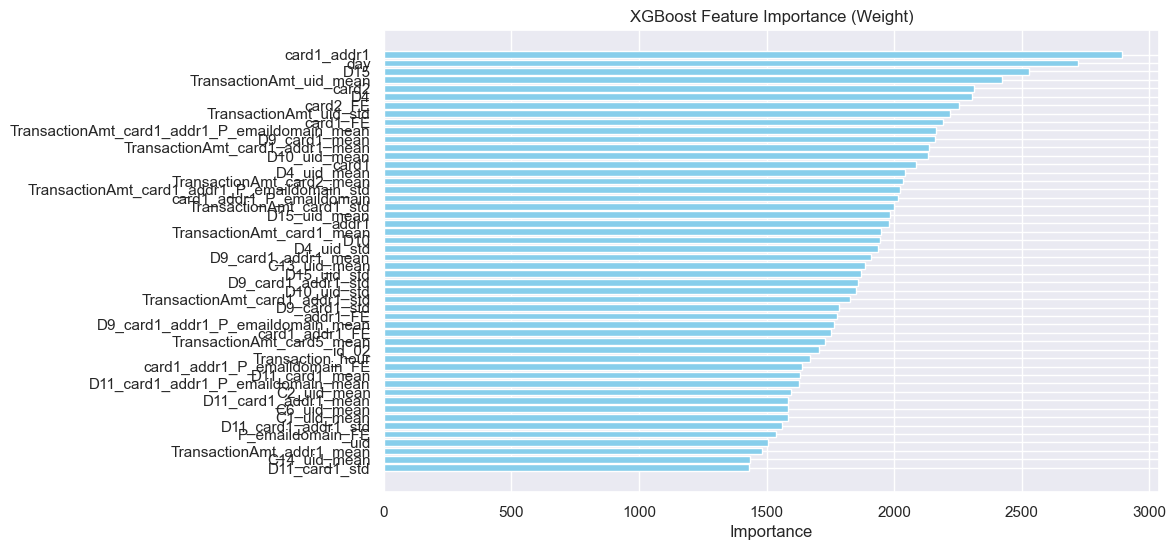

In [19]:
# Extract feature importance
xgb_feature_importance = final_xgb_model.get_booster().get_score(importance_type='weight')

# Convert to DataFrame for easier visualization
xgb_feature_importance_df = pd.DataFrame(
    list(xgb_feature_importance.items()),
    columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=False)[:50]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(xgb_feature_importance_df['Feature'], xgb_feature_importance_df['Importance'], color='skyblue')
plt.title('XGBoost Feature Importance (Weight)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()

#### LGBM - HyperOpt

In [20]:
# from lightgbm import LGBMClassifier

# def objective_lgbm(params):
#     time1 = time.time()
#     params['max_depth'] = int(params['max_depth'])
#     params['n_estimators'] = 600  # Fixed number of estimators
#     params['verbosity'] = -1  # Suppress output

#     print("\n############## New Run ################")
#     print(f"params = {params}")
    
#     FOLDS = 7
#     skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
#     score_mean = 0

#     for tr_idx, val_idx in skf.split(X_train, y_train):
#         clf = LGBMClassifier(**params)
#         X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
#         y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
#         clf.fit(X_tr, y_tr)
#         preds = clf.predict_proba(X_vl)[:, 1]
#         score = roc_auc_score(y_vl, preds)
#         score_mean += score
    
#     mean_auc = score_mean / FOLDS
#     print(f"Mean ROC_AUC: {mean_auc}")
#     time2 = time.time() - time1
#     print(f"Total Time Run: {round(time2 / 60, 2)} minutes")
#     gc.collect()
#     return -mean_auc

# space_lgbm = {
#     'max_depth': scope.int(hp.quniform('max_depth', 5, 20, 1)),
#     'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
#     'reg_alpha': hp.uniform('reg_alpha', 0, 1),
#     'reg_lambda': hp.uniform('reg_lambda', 0, 1),
#     'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
#     'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
#     'min_child_samples': scope.int(hp.quniform('min_child_samples', 10, 100, 5)),
#     'num_leaves': scope.int(hp.quniform('num_leaves', 20, 150, 10)),
# }

# trials_lgbm = Trials()
# best_lgbm = fmin(fn=objective_lgbm, space=space_lgbm, algo=tpe.suggest, max_evals=50, trials=trials_lgbm)
# print("Best parameters for LGBM: ", best_lgbm)


In [21]:
best_lgbm = {'bagging_fraction': 0.9552500251554533, 'feature_fraction': 0.9263523598979249, 'learning_rate': 0.11302589633505723, 'max_depth': 19, 'min_child_samples': 85, 'num_leaves': 150, 'reg_alpha': 0.4547602952186245, 'reg_lambda': 0.006517479648214031}

In [22]:
# Train the model on the full training data
final_lgbm_model = lgb.LGBMClassifier(
    n_estimators=600,  # Set to the same number used during tuning
    random_state=42,
    **best_lgbm
)

final_lgbm_model.fit(X_train, y_train)

# Make predictions
lgbm_preds = final_lgbm_model.predict(X_test)
lgbm_probs = final_lgbm_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, lgbm_preds)
precision = precision_score(y_test, lgbm_preds)
recall = recall_score(y_test, lgbm_preds)
f1 = f1_score(y_test, lgbm_preds)
roc_auc = roc_auc_score(y_test, lgbm_probs)

# Print evaluation metrics
print("\nEvaluation Metrics on Test Set (LightGBM):")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Optional: Display classification report
print("\nClassification Report:")
print(classification_report(y_test, lgbm_preds))

[LightGBM] [Warning] feature_fraction is set=0.9263523598979249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9263523598979249
[LightGBM] [Warning] bagging_fraction is set=0.9552500251554533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9552500251554533
[LightGBM] [Warning] feature_fraction is set=0.9263523598979249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9263523598979249
[LightGBM] [Warning] bagging_fraction is set=0.9552500251554533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9552500251554533
[LightGBM] [Info] Number of positive: 16599, number of negative: 455833
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35923
[LightGBM] [Info] Number of data points in the train set: 472432,

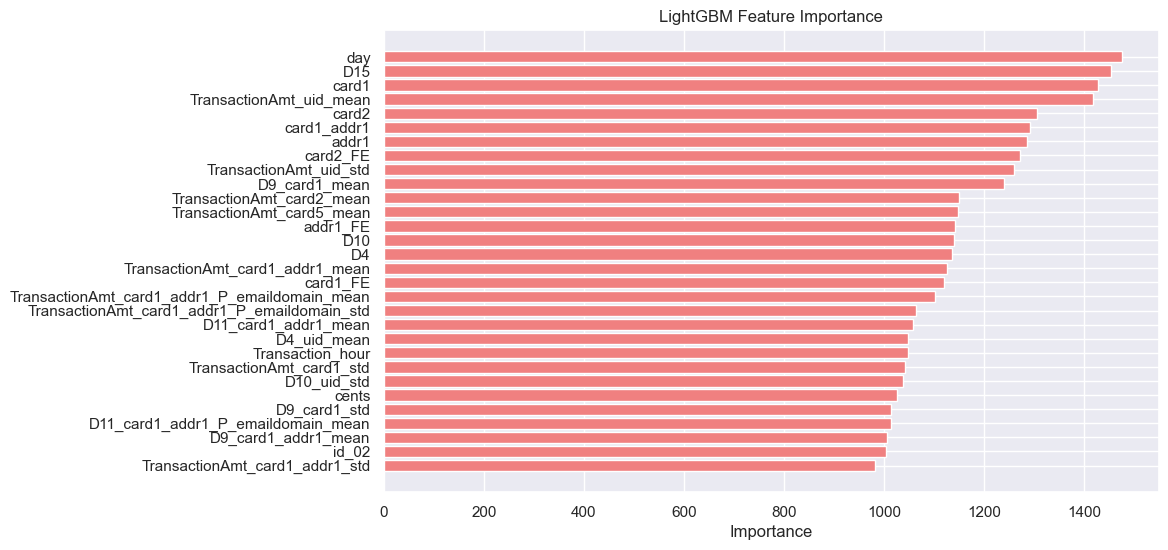

In [23]:
# Extract feature importance
lgbm_feature_importance = final_lgbm_model.feature_importances_

# Convert to DataFrame
lgbm_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgbm_feature_importance
}).sort_values(by='Importance', ascending=False)[:30]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(lgbm_feature_importance_df['Feature'], lgbm_feature_importance_df['Importance'], color='lightcoral')
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()